In [1]:
# Install Pyspark
!pip install pyspark

In [2]:
# Import Library
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline

from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [3]:
spark = SparkSession.builder.appName("Fraud Detection").getOrCreate()
df = spark.read.csv("Fraud.csv", header=True, inferSchema=True)
df.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [4]:
# Memeriksa tipe data
df.dtypes

[('step', 'int'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'int')]

In [5]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [6]:
# Menganti Nama Kolom
df = df.withColumnRenamed('type', 'tipe') \
       .withColumnRenamed('amount', 'jumlah') \
       .withColumnRenamed('nameOrig', 'nasabahAsal') \
       .withColumnRenamed('oldbalanceOrg', 'saldoAwal_nasabahAsal') \
       .withColumnRenamed('newbalanceOrig', 'saldoAkhir_nasabahAsal') \
       .withColumnRenamed('nameDest', 'nasabahTujuan') \
       .withColumnRenamed('oldbalanceDest', 'saldoAawal_nasabahTujuan') \
       .withColumnRenamed('newbalanceDest', 'saldoAkhir_nasabahTujuan') \
       .withColumnRenamed('isFraud', 'Fraud') \
       .withColumnRenamed('isFlaggedFraud', 'FlaggedFraud')

In [7]:
df.show()

+----+--------+---------+-----------+---------------------+----------------------+-------------+------------------------+------------------------+-----+------------+
|step|    tipe|   jumlah|nasabahAsal|saldoAwal_nasabahAsal|saldoAkhir_nasabahAsal|nasabahTujuan|saldoAawal_nasabahTujuan|saldoAkhir_nasabahTujuan|Fraud|FlaggedFraud|
+----+--------+---------+-----------+---------------------+----------------------+-------------+------------------------+------------------------+-----+------------+
|   1| PAYMENT|  9839.64|C1231006815|             170136.0|             160296.36|  M1979787155|                     0.0|                     0.0|    0|           0|
|   1| PAYMENT|  1864.28|C1666544295|              21249.0|              19384.72|  M2044282225|                     0.0|                     0.0|    0|           0|
|   1|TRANSFER|    181.0|C1305486145|                181.0|                   0.0|   C553264065|                     0.0|                     0.0|    1|           0|
|   

In [8]:
# Memeriksa Null
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+----+------+-----------+---------------------+----------------------+-------------+------------------------+------------------------+-----+------------+
|step|tipe|jumlah|nasabahAsal|saldoAwal_nasabahAsal|saldoAkhir_nasabahAsal|nasabahTujuan|saldoAawal_nasabahTujuan|saldoAkhir_nasabahTujuan|Fraud|FlaggedFraud|
+----+----+------+-----------+---------------------+----------------------+-------------+------------------------+------------------------+-----+------------+
|   0|   0|     0|          0|                    0|                     0|            0|                       0|                       0|    0|           0|
+----+----+------+-----------+---------------------+----------------------+-------------+------------------------+------------------------+-----+------------+



In [9]:
# Mengubah tipe data (agar bisa di proses),
df = df.withColumn("Fraud", (col("Fraud") == 1).cast(IntegerType()))

In [10]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- tipe: string (nullable = true)
 |-- jumlah: double (nullable = true)
 |-- nasabahAsal: string (nullable = true)
 |-- saldoAwal_nasabahAsal: double (nullable = true)
 |-- saldoAkhir_nasabahAsal: double (nullable = true)
 |-- nasabahTujuan: string (nullable = true)
 |-- saldoAawal_nasabahTujuan: double (nullable = true)
 |-- saldoAkhir_nasabahTujuan: double (nullable = true)
 |-- Fraud: integer (nullable = true)
 |-- FlaggedFraud: integer (nullable = true)



In [11]:
df.describe().show()

+-------+------------------+--------+------------------+-----------+---------------------+----------------------+-------------+------------------------+------------------------+--------------------+------------+
|summary|              step|    tipe|            jumlah|nasabahAsal|saldoAwal_nasabahAsal|saldoAkhir_nasabahAsal|nasabahTujuan|saldoAawal_nasabahTujuan|saldoAkhir_nasabahTujuan|               Fraud|FlaggedFraud|
+-------+------------------+--------+------------------+-----------+---------------------+----------------------+-------------+------------------------+------------------------+--------------------+------------+
|  count|            246948|  246948|            246948|     246948|               246948|                246948|       246948|                  246948|                  246948|              246948|      246948|
|   mean|10.734340832887895|    NULL| 179431.6178739261|       NULL|    884715.1915024989|     903180.8622817353|         NULL|       958175.5818214267|

In [12]:
assembler = VectorAssembler(inputCols=["jumlah", "saldoAwal_nasabahAsal",
                                       "saldoAkhir_nasabahAsal", "saldoAawal_nasabahTujuan",
                                       "saldoAkhir_nasabahTujuan", "Fraud" ], outputCol="features")
vector_df = assembler.transform(df)

In [13]:
correlation_matrix = Correlation.corr(vector_df, "features").head()[0]
print("Matriks Korelasi:\n", correlation_matrix.toArray())

Matriks Korelasi:
 [[ 1.         -0.01900918 -0.02275369  0.21651445  0.33618889  0.04788849]
 [-0.01900918  1.          0.99898833  0.09477227  0.06372463 -0.00109603]
 [-0.02275369  0.99898833  1.          0.09637744  0.06284644 -0.0078804 ]
 [ 0.21651445  0.09477227  0.09637744  1.          0.95637592 -0.00799182]
 [ 0.33618889  0.06372463  0.06284644  0.95637592  1.         -0.00443731]
 [ 0.04788849 -0.00109603 -0.0078804  -0.00799182 -0.00443731  1.        ]]


In [14]:
training_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
training_data = assembler.transform(training_data)
test_data = assembler.transform(test_data)

## EDA

Bar Chart

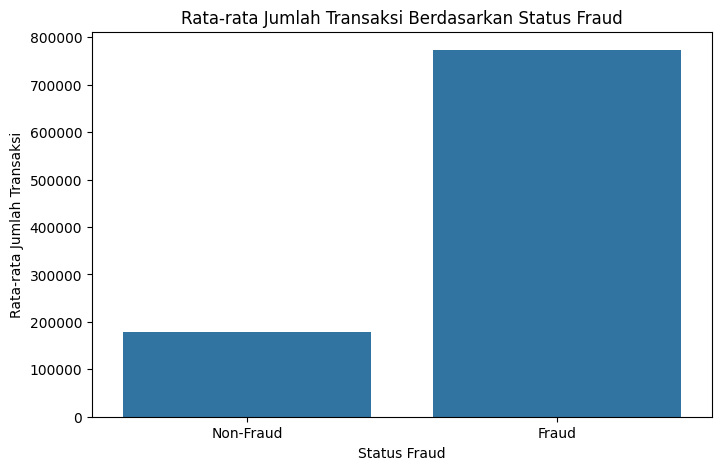

In [15]:
avg_transaction = df.groupBy('Fraud').avg('jumlah').toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x='Fraud', y='avg(jumlah)', data=avg_transaction)
plt.title('Rata-rata Jumlah Transaksi Berdasarkan Status Fraud')
plt.xlabel('Status Fraud')
plt.ylabel('Rata-rata Jumlah Transaksi')
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.show()

Pie Chart

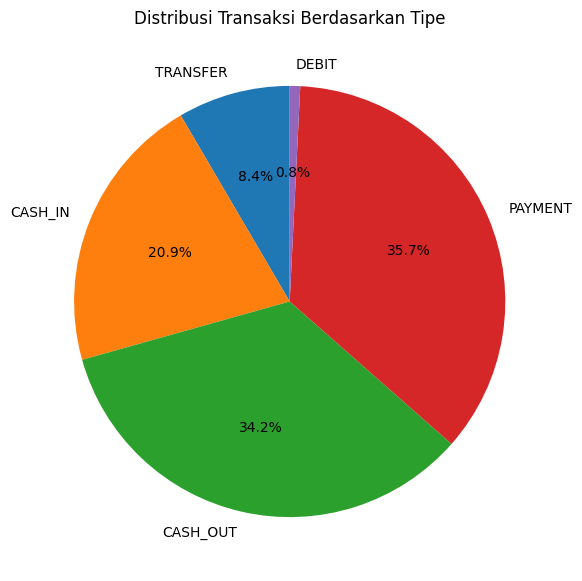

In [16]:
type_counts = df.groupBy("tipe").count().toPandas()

plt.figure(figsize=(7, 7))
plt.pie(type_counts['count'], labels=type_counts['tipe'], autopct='%1.1f%%', startangle=90)
plt.title('Distribusi Transaksi Berdasarkan Tipe')
plt.show()

Histogram

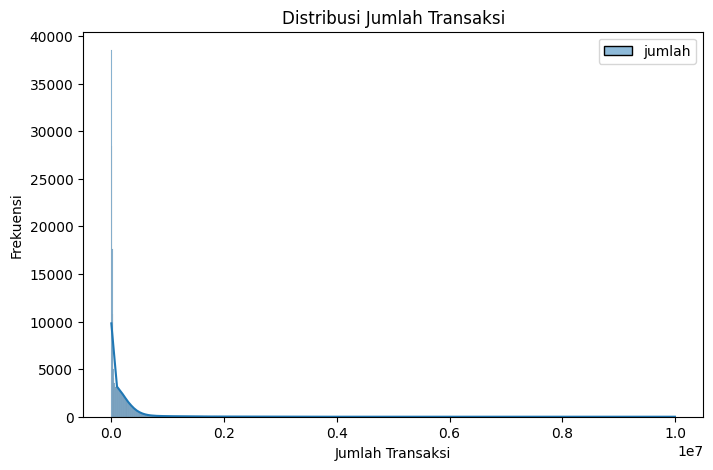

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df.select('jumlah').toPandas(), kde=True)
plt.title('Distribusi Jumlah Transaksi')
plt.xlabel('Jumlah Transaksi')
plt.ylabel('Frekuensi')
plt.show()

Heatmap

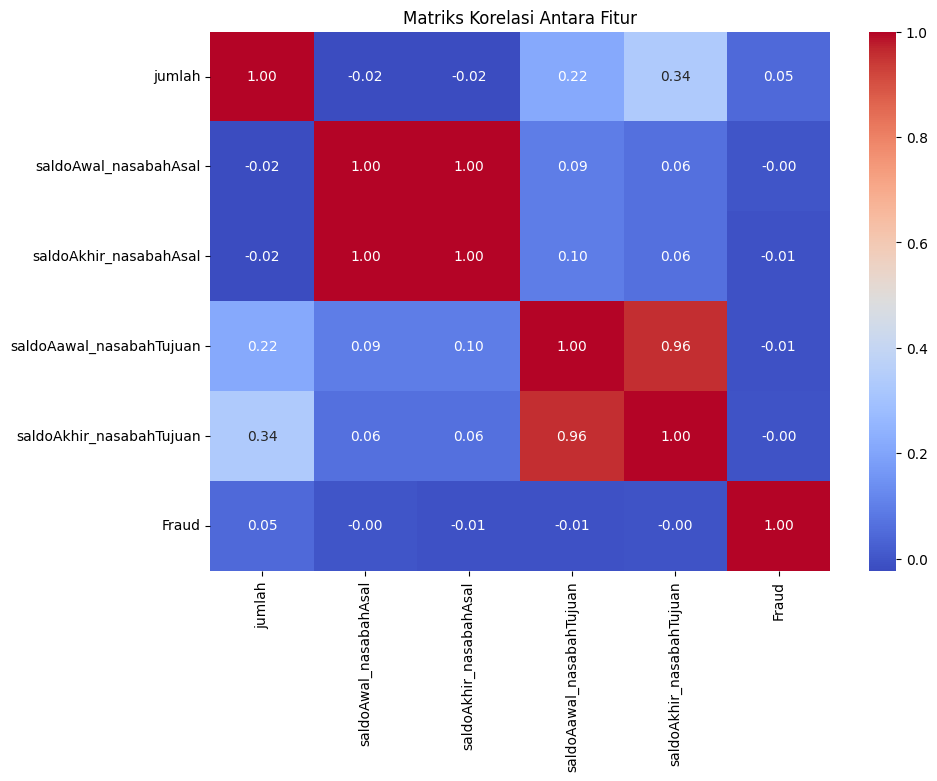

In [18]:
correlation_matrix = df.select("jumlah", "saldoAwal_nasabahAsal", "saldoAkhir_nasabahAsal",
                               "saldoAawal_nasabahTujuan", "saldoAkhir_nasabahTujuan", "Fraud").toPandas().corr()

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Matriks Korelasi Antara Fitur')
plt.show()

Boxplot

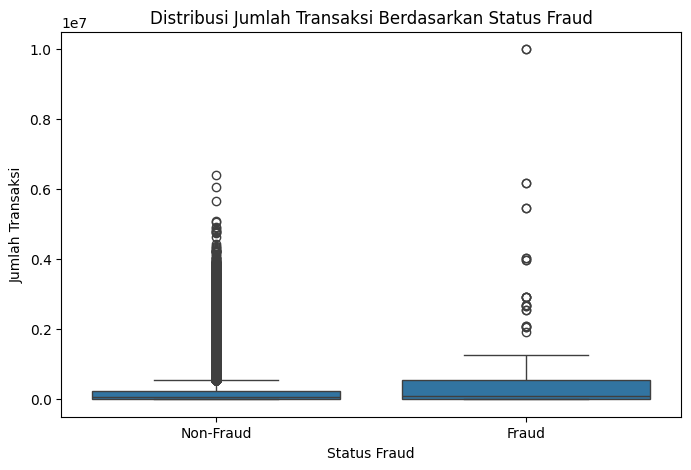

In [19]:
df_sample = df.limit(1000).toPandas()
plt.figure(figsize=(8, 5))
sns.boxplot(x='Fraud', y='jumlah', data=df.toPandas())
plt.title('Distribusi Jumlah Transaksi Berdasarkan Status Fraud')
plt.xlabel('Status Fraud')
plt.ylabel('Jumlah Transaksi')
plt.xticks([0, 1], ["Non-Fraud", "Fraud"])
plt.show()

### Gradient Boost Tree

In [20]:
gbt = GBTClassifier(labelCol="Fraud", featuresCol="features", maxIter=20)

In [21]:
gbt_model = gbt.fit(training_data)

In [22]:
gbt_predictions = gbt_model.transform(test_data)

In [23]:
gbt_evaluator = BinaryClassificationEvaluator(labelCol="Fraud", metricName="areaUnderROC")
gbt_auc = gbt_evaluator.evaluate(gbt_predictions)
print("Gradient Boost Tree AUC:", gbt_auc)

Gradient Boost Tree AUC: 1.0


### Random Forest

In [24]:
rf = RandomForestClassifier(labelCol="Fraud", featuresCol="features", numTrees=50)

In [25]:
rf_model = rf.fit(training_data)

In [26]:
rf_predictions = rf_model.transform(test_data)

In [27]:
rf_evaluator = BinaryClassificationEvaluator(labelCol="Fraud", metricName="areaUnderROC")
rf_auc = rf_evaluator.evaluate(rf_predictions)
print("Random Forest AUC:", rf_auc)

Random Forest AUC: 1.0


### Logistic Regression

In [28]:
lr = LogisticRegression(labelCol="Fraud", featuresCol="features", maxIter=10)

In [29]:
lr_model = lr.fit(training_data)

In [30]:
lr_predictions = lr_model.transform(test_data)

In [31]:
lr_evaluator = BinaryClassificationEvaluator(labelCol="Fraud", metricName="areaUnderROC")
lr_auc = lr_evaluator.evaluate(lr_predictions)
print("Logistic Regression AUC:", lr_auc)

Logistic Regression AUC: 0.9998379320124791


### Decision Tree

In [32]:
dt = DecisionTreeClassifier(labelCol="Fraud", featuresCol="features")

In [33]:
dt_model = dt.fit(training_data)

In [34]:
dt_predictions = dt_model.transform(test_data)

In [35]:
dt_evaluator = BinaryClassificationEvaluator(labelCol="Fraud", metricName="areaUnderROC")
dt_auc = dt_evaluator.evaluate(dt_predictions)
print("Decision Tree AUC:", dt_auc)

Decision Tree AUC: 1.0


## Evaluasi

In [36]:
def evaluate_model(predictions):
    evaluator = BinaryClassificationEvaluator(labelCol='Fraud', metricName="areaUnderROC")
    auc = evaluator.evaluate(predictions)
    accuracy = predictions.filter(predictions['Fraud'] == predictions['prediction']).count() / float(predictions.count())

    evaluator = MulticlassClassificationEvaluator(labelCol="Fraud", predictionCol="prediction")
    precision = evaluator.setMetricName("weightedPrecision").evaluate(predictions)
    recall = evaluator.setMetricName("weightedRecall").evaluate(predictions)
    f1 = evaluator.setMetricName("f1").evaluate(predictions)

    return auc, accuracy, precision, recall, f1

# Evaluasi model
rf_auc, rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(rf_predictions)
gbt_auc, gbt_accuracy, gbt_precision, gbt_recall, gbt_f1 = evaluate_model(gbt_predictions)
lr_auc, lr_accuracy, lr_precision, lr_recall, lr_f1 = evaluate_model(lr_predictions)
dt_auc, dt_accuracy, dt_precision, dt_recall, dt_f1 = evaluate_model(dt_predictions)

In [37]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "AUC", "Accuracy", "Precision", "Recall", "F1 Score"]

# Tambahkan hasil evaluasi ke tabel
table.add_row(["Random Forest", f"{rf_auc:.4f}", f"{rf_accuracy:.4f}", f"{rf_precision:.4f}", f"{rf_recall:.4f}", f"{rf_f1:.4f}"])
table.add_row(["Gradient Boosted Trees", f"{gbt_auc:.4f}", f"{gbt_accuracy:.4f}", f"{gbt_precision:.4f}", f"{gbt_recall:.4f}", f"{gbt_f1:.4f}"])
table.add_row(["Logistic Regression", f"{lr_auc:.4f}", f"{lr_accuracy:.4f}", f"{lr_precision:.4f}", f"{lr_recall:.4f}", f"{lr_f1:.4f}"])
table.add_row(["Decision Tree", f"{dt_auc:.4f}", f"{dt_accuracy:.4f}", f"{dt_precision:.4f}", f"{dt_recall:.4f}", f"{dt_f1:.4f}"])
print(table)

+------------------------+--------+----------+-----------+--------+----------+
|         Model          |  AUC   | Accuracy | Precision | Recall | F1 Score |
+------------------------+--------+----------+-----------+--------+----------+
|     Random Forest      | 1.0000 |  1.0000  |   1.0000  | 1.0000 |  1.0000  |
| Gradient Boosted Trees | 1.0000 |  1.0000  |   1.0000  | 1.0000 |  1.0000  |
|  Logistic Regression   | 0.9998 |  1.0000  |   1.0000  | 1.0000 |  1.0000  |
|     Decision Tree      | 1.0000 |  1.0000  |   1.0000  | 1.0000 |  1.0000  |
+------------------------+--------+----------+-----------+--------+----------+


## Hyperparameter Tuning

In [39]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Fraud", metricName="areaUnderROC")

# Parameter Grid for GBT
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.stepSize, [0.1, 0.2]) \
    .build()

# CrossValidator for GBT
gbt_cv = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_param_grid,
                        evaluator=evaluator, numFolds=3)

# Fit GBT Model
gbt_tuned_model = gbt_cv.fit(training_data)
gbt_tuned_predictions = gbt_tuned_model.transform(test_data)

# Evaluate Tuned GBT
gbt_tuned_auc = evaluator.evaluate(gbt_tuned_predictions)
print(f"Tuned Gradient Boosted Trees AUC: {gbt_tuned_auc:.4f}")

Tuned Gradient Boosted Trees AUC: 1.0000


In [41]:
# Parameter Grid for Random Forest
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

# CrossValidator for RF
rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_param_grid,
                       evaluator=evaluator, numFolds=3)

# Fit RF Model
rf_tuned_model = rf_cv.fit(training_data)
rf_tuned_predictions = rf_tuned_model.transform(test_data)

# Evaluate Tuned RF
rf_tuned_auc = evaluator.evaluate(rf_tuned_predictions)
print(f"Tuned Random Forest AUC: {rf_tuned_auc:.4f}")

Tuned Random Forest AUC: 1.0000
